# 0. Install python requirement
We also need some additional python packages to process and observe the data

In [1]:
!pip install pandas seaborn

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load Chopchop data

Our goal is to simply observe the characteristics of the Guide with high efficiency. Therefore, we only care about'GUIDE' and'EFFICIENCY' at this time.

In [3]:
data = pd.read_csv('data/danrer11_chopchop_all.csv',index_col=0)[['GUIDE','EFFICIENCY']]

View data

In [4]:
data.head(5)

,GUIDE,EFFICIENCY
0,CGATGTTGGGAAACTTGGGTAGG,70.94
1,GATGAATGAGGAACGCGCAGCGG,64.36
2,TCAATTCATTATTCACGCGGAGG,59.94
3,ACGCGTCTTGAGCACTCGCTGGG,51.73
4,AAGATCGATGTTGGGAAACTTGG,38.63


# 2. Filter out Good and Bad data

In order to distinguish good from bad, we set a 50% threshold for the efficiency.

In [5]:
# Set the threshold
threshold = 50
# Filter out good and bad data
data_good = data[data['EFFICIENCY'] > threshold]
data_bad = data[data['EFFICIENCY'] <= threshold]

In [6]:
# Data with high efficiency
data_good.head(5)

,GUIDE,EFFICIENCY
0,CGATGTTGGGAAACTTGGGTAGG,70.94
1,GATGAATGAGGAACGCGCAGCGG,64.36
2,TCAATTCATTATTCACGCGGAGG,59.94
3,ACGCGTCTTGAGCACTCGCTGGG,51.73
6,CACGCGCACGGAGATGAATGAGG,63.35


In [7]:
# Data with low efficiency
data_bad.head(5)

,GUIDE,EFFICIENCY
4,AAGATCGATGTTGGGAAACTTGG,38.63
5,GACTCAAAAGCGCTACTTACTGG,35.21
11,ACCTCGACTCATACACATTCAGG,41.25
15,AACGCGTCTTGAGCACTCGCTGG,38.80
21,CATACACATTCAGGATACATTGG,45.37


# 3. Transform Data

## One-hot encoding

In [8]:
encoding = {'A':np.array([1,0,0,0]),
            'C':np.array([0,1,0,0]),
            'G':np.array([0,0,1,0]),
            'T':np.array([0,0,0,1])}

def one_hot(guide,encoding):
    data = np.zeros((4,len(guide)))
    assert data.shape == (4,23)
    for i in range(data.shape[-1]):
        data[:,i] = encoding[guide[i]]
    return data

#print(one_hot('CTGATCACGGCTGAAGGACTCGG',encoding))

def batch_one_hot(data,encoding):
    guides = np.zeros((len(data),4,23))
    i=0
    for guide in data['GUIDE']:
        guides[i] = one_hot(guide,encoding)
        i+=1
    return guides

guides_good = batch_one_hot(data_good,encoding)
guides_bad = batch_one_hot(data_bad,encoding)
guides = batch_one_hot(data,encoding)
print('Good dataset size:',guides_good.shape)
print('Bad dataset size:',guides_bad.shape)
print('All dataset size:',guides.shape)

Good dataset size: (159936, 4, 23)
Bad dataset size: (123090, 4, 23)
All dataset size: (283026, 4, 23)


# Observe statistics of GUIDE

## High Efficiency

Probability distribution for all 23 positions.

The colour refers to the probability. Specifically, white indicates a probability of 0, and dark red indicates a probability of 1.

For example, the 22 and 23 positions in the figure are dark red on the G row, which means that most of the guide has G (Guanine) at the 22 and 23 positions.

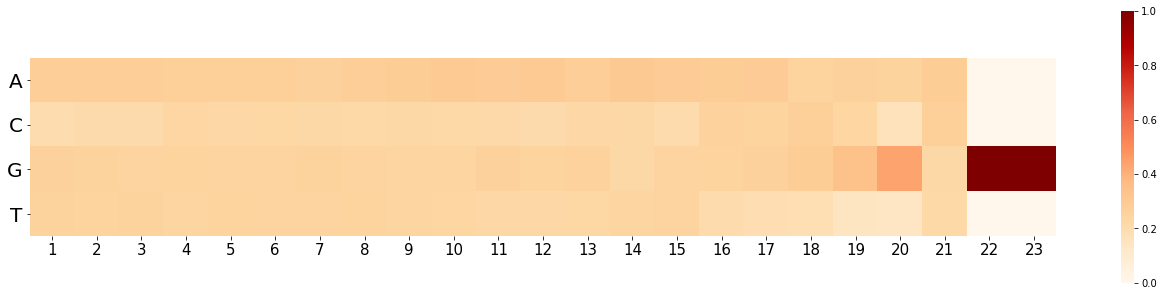

In [9]:
input_matrix = guides_good.sum(axis = 0)
plt.figure(figsize=(23,5))
plt.xticks(fontsize=15)
plt.yticks(fontsize=20)
sns.heatmap((input_matrix)/input_matrix.sum(axis = 0),
            cmap="OrRd",
            xticklabels=range(1,23+1),
            yticklabels=encoding.keys(),square = True)
plt.yticks(rotation=360)
plt.savefig("good_normal.png")

We can scale the probability for a better view. Therefore, the color does not strictly represent the probability. But color still has a positive correlation with probability.

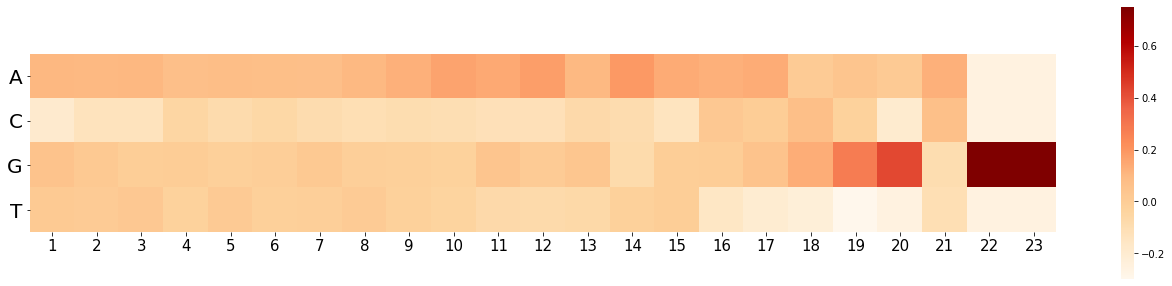

In [10]:
input_matrix = guides_good.sum(axis = 0)
plt.figure(figsize=(23,5))
plt.xticks(fontsize=15)
plt.yticks(fontsize=20)
sns.heatmap((input_matrix-input_matrix.mean(axis = 0))/input_matrix.max(axis = 0),
            cmap="OrRd",
            xticklabels=range(1,23+1),
            yticklabels=encoding.keys(),square = True)
plt.yticks(rotation=360)
plt.savefig("good_view.png")

## Bad

Probability distribution for all 23 positions.

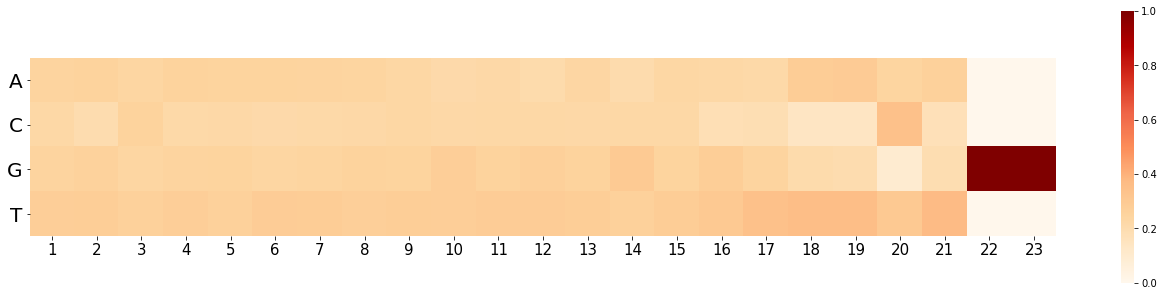

In [11]:
input_matrix = guides_bad.sum(axis = 0)
plt.figure(figsize=(23,5))
plt.xticks(fontsize=15)
plt.yticks(fontsize=20)
sns.heatmap((input_matrix)/input_matrix.sum(axis = 0),
            cmap="OrRd",
            xticklabels=range(1,23+1),
            yticklabels=encoding.keys(),square = True)
plt.yticks(rotation=360)
plt.savefig("bad_normal.png")

We can scale the probability for a better view. Therefore, the color does not strictly represent the probability. But color still has a positive correlation with probability.

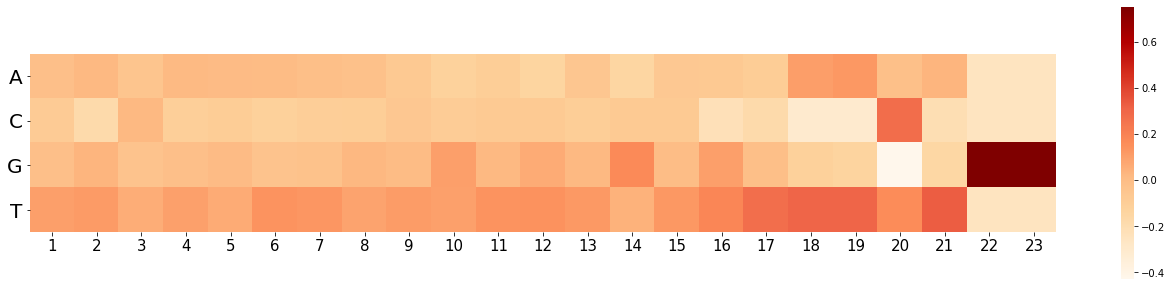

In [12]:
input_matrix = guides_bad.sum(axis = 0)
plt.figure(figsize=(23,5))
plt.xticks(fontsize=15)
plt.yticks(fontsize=20)
sns.heatmap((input_matrix-input_matrix.mean(axis = 0))/input_matrix.max(axis = 0),
            cmap="OrRd",
            xticklabels=range(1,23+1),
            yticklabels=encoding.keys(),square = True)
plt.yticks(rotation=360)
plt.savefig("bad_view.png")